## **DEMANDA Y TEMPERATURA:** INFERENCIA Y ANOVA

#### **1) Importamos libreria útiles:**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set(style="darkgrid")
maxScatter = 3000

#### **2) Cargamos datos:**

- Comprobamos que trabajamos en el directorio correcto y cargamos datos de carpeta "data":

In [20]:
dir = os.getcwd()
DIR = dir
print('Current working directory:', os.getcwd())


# Nos guardamos los datos que queremos en un dataframe usando pandas
dataframe = pd.read_csv('..\data\G02_DATOS_DEM_G1.csv', sep=',', verbose=True)
dataframe['FECHA'] = pd.to_datetime(dataframe['FECHA'], format='%d/%m/%Y')

def permutar_DIASEM(x):
    return (x + 5) % 7 + 1

dataframe['DIASEM'] = dataframe['DIASEM'].apply(permutar_DIASEM)
dataframe

Current working directory: c:\Users\serov\Documents\GitHub\TRABAJO-1-ESTADISTICA-DESCRIPTIVA\notebooks
Tokenization took: 2.00 ms
Type conversion took: 2.01 ms
Parser memory cleanup took: 0.00 ms


,FECHA,DEM,TMAX,TMIN,FEST,ANNO,MES,DIA,DIASEM
0,2014-01-01,695.150000,14.500000,4.900000,1,2014,1,1,3
1,2014-01-02,848.520000,17.900000,8.300000,0,2014,1,2,4
2,2014-01-03,842.250000,18.000000,10.800000,0,2014,1,3,5
3,2014-01-04,790.870000,14.800000,9.900000,0,2014,1,4,6
4,2014-01-05,765.880000,15.500000,8.300000,0,2014,1,5,7
...,...,...,...,...,...,...,...,...,...
2950,2022-01-29,897.963540,14.928054,7.128469,0,2022,1,29,6
2951,2022-01-30,883.656025,14.921389,7.131950,0,2022,1,30,7
2952,2022-01-31,1016.937007,14.914723,7.135431,0,2022,1,31,1
2953,2022-02-01,1014.929731,14.908058,7.138912,0,2022,2,1,2


#### **3) Estimación TMAX esperada en julio:**

In [25]:
import scipy.stats as stats

stats.norm.interval(alpha=0.95,
                 loc=np.mean(dataframe[dataframe['MES'] == 7]['TMAX']),
                 scale=stats.sem(dataframe[dataframe['MES'] == 7]['TMAX']))

(28.883724709361093, 29.25892353933904)

#### **4) Distribución TMAX según los meses del año:**

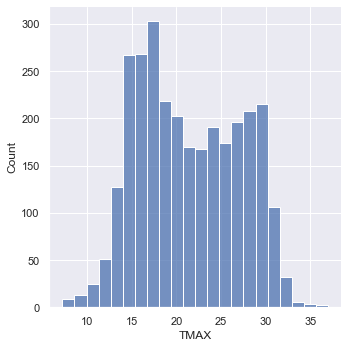

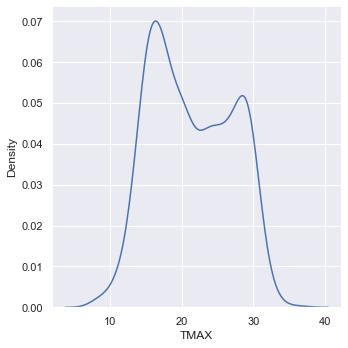

In [26]:
sns.displot(dataframe['TMAX'])
sns.displot(dataframe['TMAX'], kind="kde", bw_adjust=1)

#### **5) Distribución de la demanda de los laborables según los meses del año:**

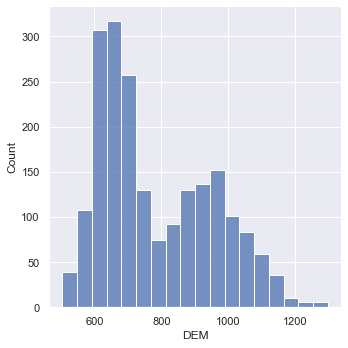

In [27]:
dataframe_dias_festivos = dataframe[dataframe['FEST'] == 1]
dataframe_sab_dom = dataframe[dataframe['DIASEM'] >= 6]

# Unimos con días festivos
dataframe_no_laborales = pd.concat([dataframe_dias_festivos, dataframe_sab_dom]).sort_values(by='FECHA')
# Quitamos duplicados
dataframe_no_laborales = dataframe_no_laborales.drop_duplicates()
dataframe_laborales = dataframe[dataframe['FECHA'].isin(dataframe_no_laborales['FECHA']) == False]
sns.displot(dataframe_laborales['DEM'])

#### **6) ANOVA de la demanda de los laborales con los meses:**

In [34]:

# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)
# calculate SSTR and update anova table
x_bar = dataframe_laborales['DEM'].mean()
SSTR = dataframe_laborales.groupby('MES').count() * (dataframe_laborales.groupby('MES').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['DEM'].sum()

# calculate SSE and update anova table
SSE = (dataframe_laborales.groupby('MES').count() - 1) * dataframe_laborales.groupby('MES').std()**2
anova_table['SS']['Within Groups'] = SSE['DEM'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['DEM'].sum() + SSE['DEM'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = dataframe_laborales['MES'].nunique() - 1
anova_table['df']['Within Groups'] = dataframe_laborales.shape[0] - dataframe_laborales['MES'].nunique()
anova_table['df']['Total'] = dataframe_laborales.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,46877593.670329,11,4261599.424575,755.054082,0.0,1.999077
Within Groups,11463163.548962,2031,5644.098252,,,
Total,58340757.21929,2042,28570.400205,,,
